
# Time-Series Forecasting: ARIMA, SARIMA, LSTM, and GRU (Fast-Run, Python 3.13 Compatible)

This notebook forecasts weekly **Average Selling Price (ASP)** for the Avocado dataset using four models:
- **ARIMA** (statsmodels)
- **SARIMA** (statsmodels)
- **LSTM** (TensorFlow/Keras)
- **GRU** (TensorFlow/Keras)

Design goals:
- **Fast execution**: tiny hyperparameter grids, low epoch counts, small networks.
- **Python 3.13 compatibility**: relies primarily on statsmodels/numpy/pandas/matplotlib.
- **Clean evaluation**: RMSE and MAPE on a hold-out validation window; 24-week forecast at the end.


In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


## Load & Prepare Weekly National Series (ASP)

In [3]:

# Load
DATA_PATH = os.path.join('..', 'data', 'avocado.csv') if os.path.exists('..') else '/mnt/data/avocado.csv'
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]
df['date'] = pd.to_datetime(df['date'])

# Build weekly national ASP (mean) and Volume (sum)
weekly_nat = (df.set_index('date')
                .resample('W')
                .agg({'averageprice':'mean', 'total_volume':'sum'})
                .dropna())

series = weekly_nat['averageprice'].copy()
series.name = 'ASP'

print(series.head())
print('Length:', len(series))

# Train/validation split (85/15)
split_idx = int(len(series)*0.85)
y_train = series.iloc[:split_idx]
y_valid = series.iloc[split_idx:]

print('Train:', y_train.index.min(), 'to', y_train.index.max(), 'n=', len(y_train))
print('Valid:', y_valid.index.min(), 'to', y_valid.index.max(), 'n=', len(y_valid))

def adf_test(s):
    res = adfuller(s.dropna())
    return {'adf_stat': res[0], 'p_value': res[1]}

print('ADF (train):', adf_test(y_train))


date
2015-01-04    1.301296
2015-01-11    1.370648
2015-01-18    1.391111
2015-01-25    1.397130
2015-02-01    1.247037
Freq: W-SUN, Name: ASP, dtype: float64
Length: 169
Train: 2015-01-04 00:00:00 to 2017-09-24 00:00:00 n= 143
Valid: 2017-10-01 00:00:00 to 2018-03-25 00:00:00 n= 26
ADF (train): {'adf_stat': np.float64(-1.040588445931484), 'p_value': np.float64(0.7381743603877411)}


## Helper: quick fit and forecast wrappers

In [6]:

def evaluate_forecast(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

def plot_validation(y_train, y_valid, y_pred, title, ylabel='ASP'):
    plt.figure()
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_valid.index, y_valid, label='Valid')
    plt.plot(y_valid.index, y_pred, label='Forecast')
    plt.title(title); plt.xlabel('Date'); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

def future_index(last_idx, steps=24, freq='W'):
    return pd.date_range(start=last_idx + pd.tseries.frequencies.to_offset(freq), periods=steps, freq=freq)


## 1) ARIMA (small, non-seasonal)

Best ARIMA: (1, 1, 0) AIC= -438.60459789864086
ARIMA — RMSE: 0.17157150397834775 MAPE: 0.27736824322653214


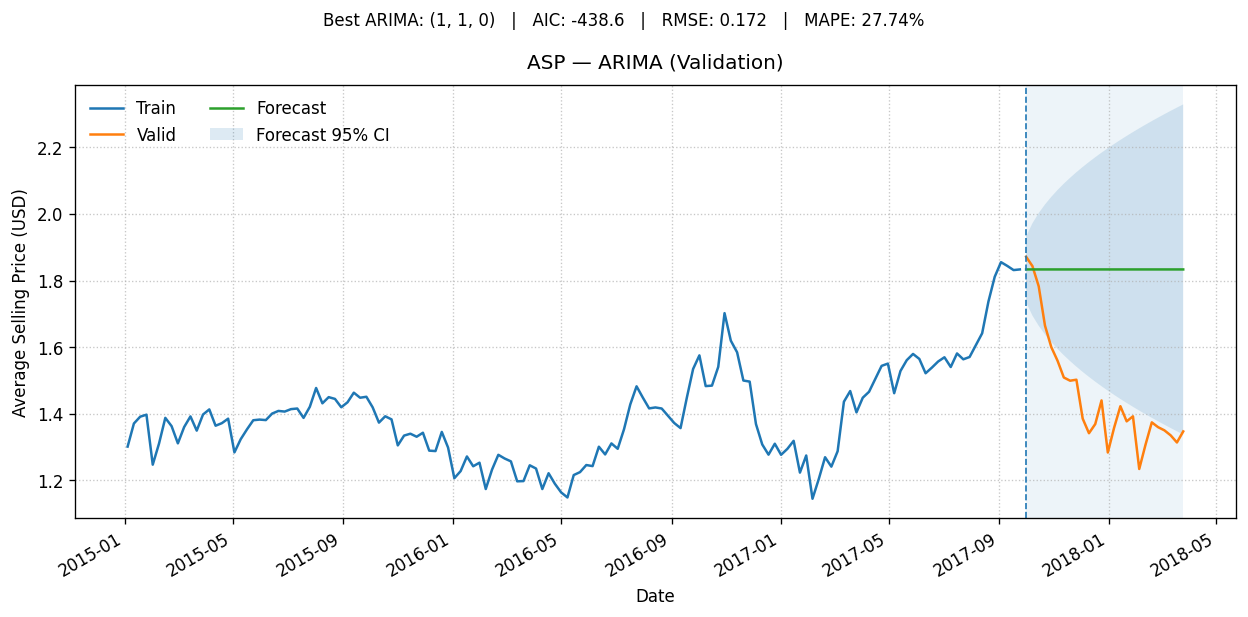

In [17]:
# Simple ARIMA search over a tiny set to keep runtime small
candidates = [(0,1,1), (1,1,0), (1,1,1)]
best = {'aic': np.inf, 'order': None, 'res': None}

for order in candidates:
    try:
        res = SARIMAX(y_train, order=order, seasonal_order=(0,0,0,0),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
        if res.aic < best['aic']:
            best = {'aic': res.aic, 'order': order, 'res': res}
    except Exception:
        continue

print('Best ARIMA:', best['order'], 'AIC=', best['aic'])
arima_pred = best['res'].get_forecast(steps=len(y_valid)).predicted_mean
arima_rmse, arima_mape = evaluate_forecast(y_valid, arima_pred)
print('ARIMA — RMSE:', arima_rmse, 'MAPE:', arima_mape)
#plot_validation(y_train, y_valid, arima_pred, 'ASP — ARIMA (Validation)')

from matplotlib.dates import AutoDateLocator, DateFormatter

# Recompute forecast to pull 95% CI
_fc = best['res'].get_forecast(steps=len(y_valid))
arima_pred = _fc.predicted_mean
_ci = _fc.conf_int(alpha=0.05)
ci_lo = _ci.iloc[:, 0]
ci_hi = _ci.iloc[:, 1]

fig, ax = plt.subplots(figsize=(10.5, 5.2), dpi=120)

# Train & validation series
ax.plot(y_train.index, y_train, label='Train')
ax.plot(y_valid.index, y_valid, label='Valid')

# Forecast + uncertainty
ax.plot(y_valid.index, arima_pred, label='Forecast')
ax.fill_between(y_valid.index, ci_lo, ci_hi, alpha=0.15, label='Forecast 95% CI')

# Mark the validation window and split
ax.axvspan(y_valid.index[0], y_valid.index[-1], alpha=0.08)
ax.axvline(y_valid.index[0], linestyle='--', linewidth=1)

# Titles (headline + compact subtitle with model + metrics)
ax.set_title('ASP — ARIMA (Validation)', pad=10)
fig.suptitle(
    f'Best ARIMA: {best["order"]}   |   AIC: {best["aic"]:.1f}   |   '
    f'RMSE: {arima_rmse:.3f}   |   MAPE: {arima_mape:.2%}',
    y=0.98, fontsize=10
)

# Axes formatting
ax.set_xlabel('Date')
ax.set_ylabel('Average Selling Price (USD)')
ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)

# Readable dates
locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Legend & layout
ax.legend(frameon=False, ncol=2, loc='upper left')
fig.tight_layout()
# fig.savefig('../reports/figures/arima_validation.png', bbox_inches='tight')  # optional
plt.show()

## 2) SARIMA (seasonal, weekly seasonality m=52)

C:\Users\patki\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA: (0, 1, 1) (1, 0, 1, 52) AIC= -256.20927536660645
SARIMA — RMSE: 0.15334238554753185 MAPE: 0.26305949616941277


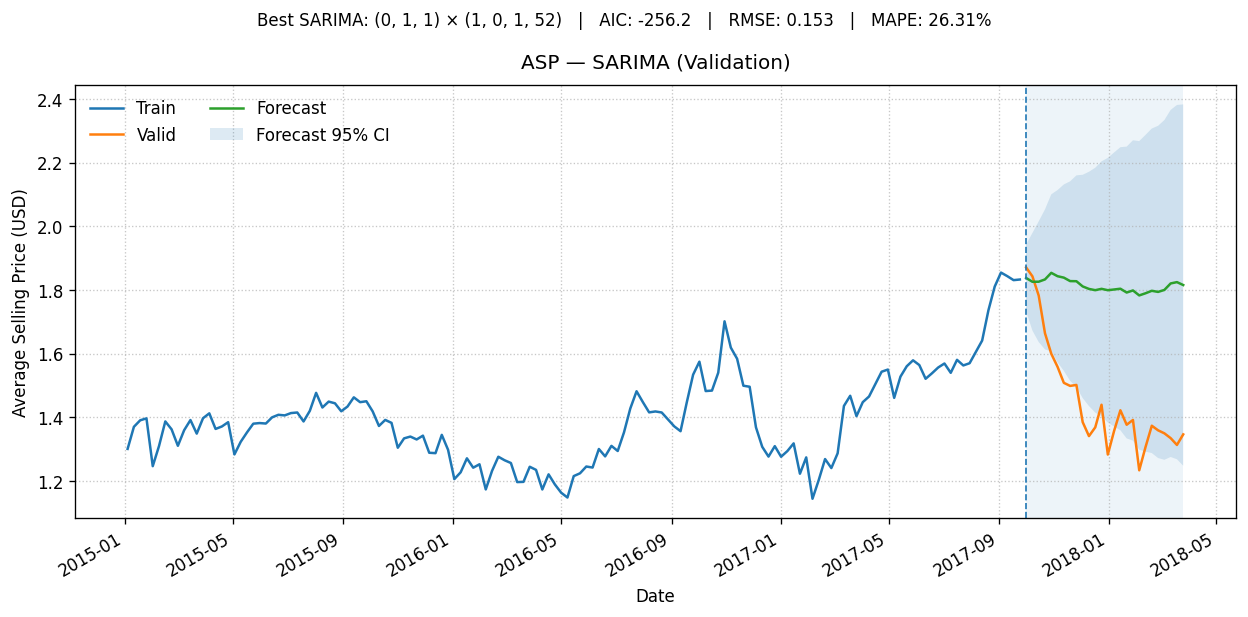

In [18]:
# Tiny SARIMA candidate set to avoid long runs
seasonal_period = 52
scandidates = [((0,1,1),(0,1,1,seasonal_period)),
               ((1,1,1),(0,1,1,seasonal_period)),
               ((1,1,0),(0,1,1,seasonal_period)),
               ((0,1,1),(1,0,1,seasonal_period))]

sbest = {'aic': np.inf, 'order': None, 'sorder': None, 'res': None}
for order, sorder in scandidates:
    try:
        res = SARIMAX(y_train, order=order, seasonal_order=sorder,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
        if res.aic < sbest['aic']:
            sbest = {'aic': res.aic, 'order': order, 'sorder': sorder, 'res': res}
    except Exception:
        continue

print('Best SARIMA:', sbest['order'], sbest['sorder'], 'AIC=', sbest['aic'])
sarima_pred = sbest['res'].get_forecast(steps=len(y_valid)).predicted_mean
sarima_rmse, sarima_mape = evaluate_forecast(y_valid, sarima_pred)
print('SARIMA — RMSE:', sarima_rmse, 'MAPE:', sarima_mape)
#plot_validation(y_train, y_valid, sarima_pred, 'ASP — SARIMA (Validation)')

from matplotlib.dates import AutoDateLocator, DateFormatter

# === Forecast objects & confidence bands ===
_fc = sbest['res'].get_forecast(steps=len(y_valid))
sarima_pred = _fc.predicted_mean
_ci = _fc.conf_int(alpha=0.05)   # 95% CI
ci_lo = _ci.iloc[:, 0]
ci_hi = _ci.iloc[:, 1]

# === Professional plot ===
fig, ax = plt.subplots(figsize=(10.5, 5.2), dpi=120)

# Train & Valid
ax.plot(y_train.index, y_train, label='Train')
ax.plot(y_valid.index, y_valid, label='Valid')

# Forecast + CI
ax.plot(y_valid.index, sarima_pred, label='Forecast')
ax.fill_between(y_valid.index, ci_lo, ci_hi, alpha=0.15, label='Forecast 95% CI')

# Mark the validation window & split
ax.axvspan(y_valid.index[0], y_valid.index[-1], alpha=0.08)
ax.axvline(y_valid.index[0], linestyle='--', linewidth=1)

# Titles (headline + subtitle with model + metrics)
ax.set_title('ASP — SARIMA (Validation)', pad=10)
fig.suptitle(
    f'Best SARIMA: {sbest["order"]} × {sbest["sorder"]}   |   '
    f'AIC: {sbest["aic"]:.1f}   |   RMSE: {sarima_rmse:.3f}   |   MAPE: {sarima_mape:.2%}',
    y=0.98, fontsize=10
)

# Axes formatting
ax.set_xlabel('Date')
ax.set_ylabel('Average Selling Price (USD)')
ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)

# Readable date ticks
locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Legend & layout
ax.legend(frameon=False, ncol=2, loc='upper left')
fig.tight_layout()

# Optional: save for README/screenshots
# fig.savefig('../reports/figures/sarima_validation.png', bbox_inches='tight')
plt.show()

## 3) LSTM (optional — runs only if TensorFlow is available)

In [19]:

# LSTM/GRU helpers
def make_supervised(series, window=12):
    X, y = [], []
    vals = series.values.astype('float32')
    for i in range(len(vals)-window):
        X.append(vals[i:i+window])
        y.append(vals[i+window])
    X = np.array(X)[:, :, None]  # (samples, timesteps, features=1)
    y = np.array(y)
    return X, y

def train_test_split_seq(series, window=12, valid_len=None):
    if valid_len is None:
        valid_len = int(len(series)*0.15)
    train_series = series.iloc[:-valid_len]
    valid_series = series.iloc[-valid_len:]
    Xtr, ytr = make_supervised(train_series, window)
    Xv, yv = make_supervised(series[-(valid_len+window):], window)
    # align validation indices
    v_index = series.index[-len(yv):]
    return Xtr, ytr, Xv, yv, v_index

def try_import_tf():
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras import layers
        return tf, keras, layers
    except Exception as e:
        print('TensorFlow not available; skipping LSTM/GRU. Error:', e)
        return None, None, None

tf, keras, layers = try_import_tf()


LSTM — RMSE: 0.04265623626804519 MAPE: 0.13706828554903955


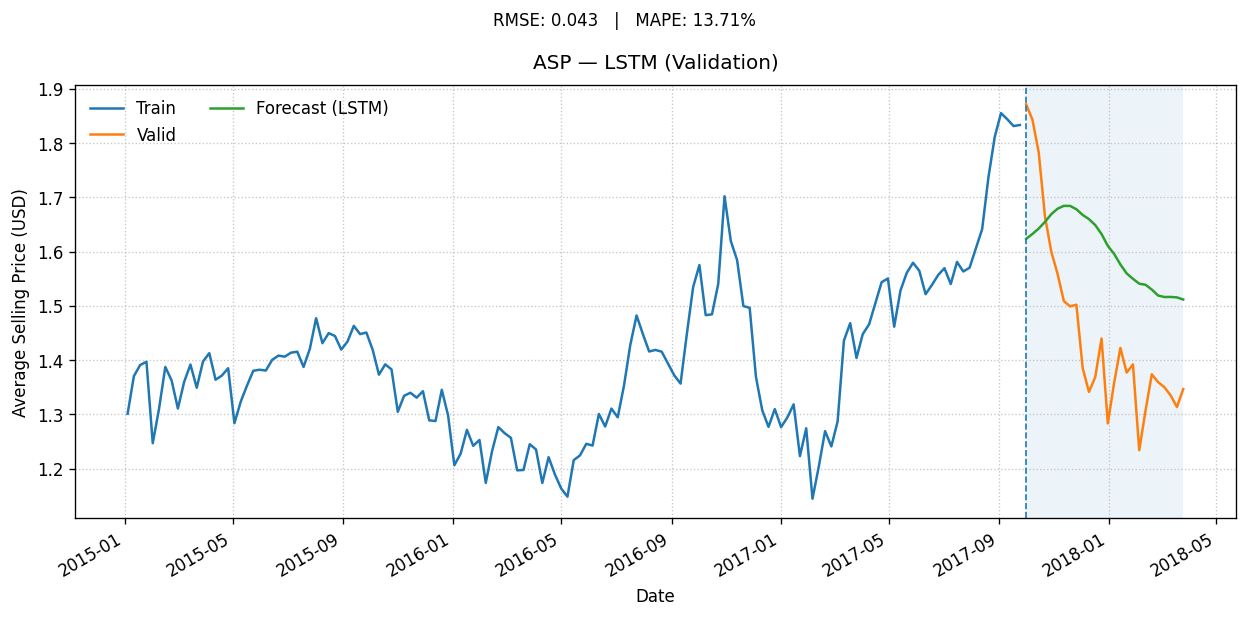

In [21]:

lstm_pred_series = None
lstm_rmse = None
lstm_mape = None

if tf is not None:
    window = 12
    Xtr, ytr, Xv, yv, v_index = train_test_split_seq(series, window=window, valid_len=len(y_valid))
    model = keras.Sequential([
        layers.Input(shape=(window,1)),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(Xtr, ytr, epochs=8, batch_size=32, validation_data=(Xv, yv), callbacks=[es], verbose=0)
    yhat = model.predict(Xv, verbose=0).ravel()
    lstm_rmse, lstm_mape = evaluate_forecast(y_valid, pd.Series(yhat, index=v_index))
    lstm_pred_series = pd.Series(yhat, index=v_index)
    print('LSTM — RMSE:', lstm_rmse, 'MAPE:', lstm_mape)

    # plt.figure()
    # plt.plot(y_train.index, y_train, label='Train')
    # plt.plot(y_valid.index, y_valid, label='Valid')
    # plt.plot(v_index, yhat, label='LSTM Forecast')
    # plt.title('ASP — LSTM (Validation)'); plt.xlabel('Date'); plt.ylabel('ASP'); plt.legend(); plt.tight_layout(); plt.show()

    from matplotlib.dates import AutoDateLocator, DateFormatter

    # Ensure forecast is a pandas Series with aligned index
    lstm_pred_series = pd.Series(yhat, index=v_index)
    
    fig, ax = plt.subplots(figsize=(10.5, 5.2), dpi=120)
    
    # Train & validation
    ax.plot(y_train.index, y_train, label='Train')
    ax.plot(y_valid.index, y_valid, label='Valid')
    
    # LSTM forecast (no CI for neural nets)
    ax.plot(lstm_pred_series.index, lstm_pred_series, label='Forecast (LSTM)')
    
    # Visually mark the validation window & split
    ax.axvspan(y_valid.index[0], y_valid.index[-1], alpha=0.08)
    ax.axvline(y_valid.index[0], linestyle='--', linewidth=1)
    
    # Titles (headline + compact subtitle with metrics)
    ax.set_title('ASP — LSTM (Validation)', pad=10)
    fig.suptitle(
        f'RMSE: {lstm_rmse:.3f}   |   MAPE: {lstm_mape:.2%}',
        y=0.98, fontsize=10
    )
    
    # Axes formatting
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Selling Price (USD)')
    ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
    
    # Readable dates
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Legend & layout
    ax.legend(frameon=False, ncol=2, loc='upper left')
    fig.tight_layout()
    # fig.savefig('../reports/figures/lstm_validation.png', bbox_inches='tight')  # optional
    plt.show()
else:
    print('Skipping LSTM section (TensorFlow not installed).')


## 4) GRU (optional — runs only if TensorFlow is available)

GRU — RMSE: 0.00982181730543685 MAPE: 0.05818181304339632


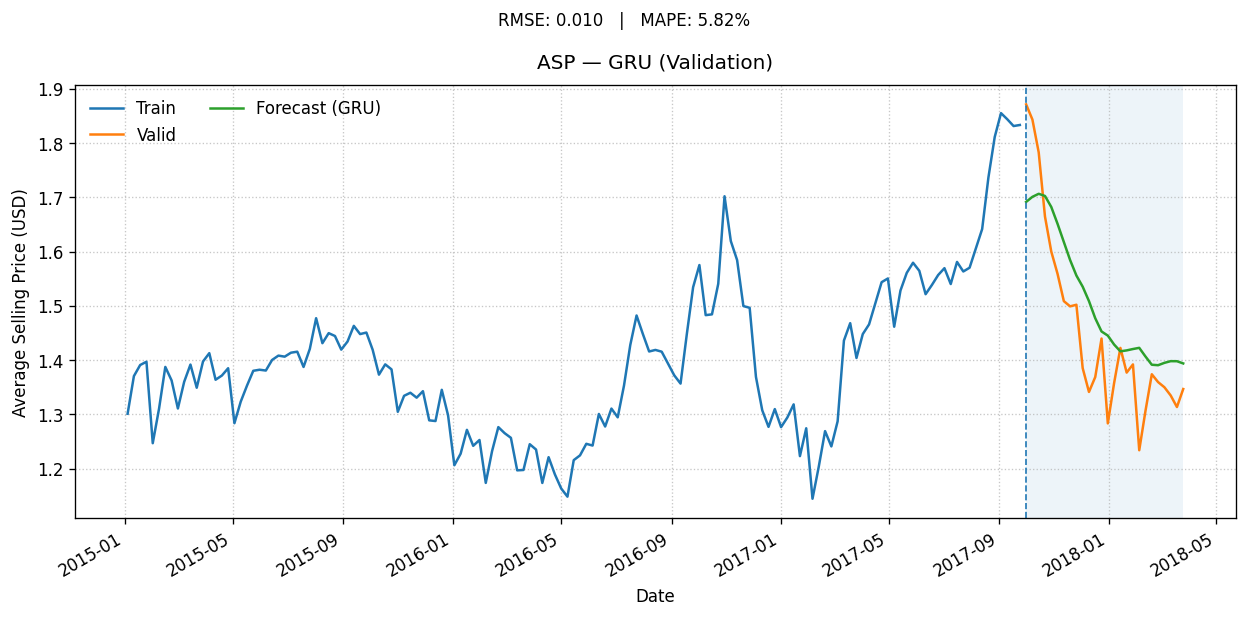

In [22]:

gru_pred_series = None
gru_rmse = None
gru_mape = None

if tf is not None:
    window = 12
    Xtr, ytr, Xv, yv, v_index = train_test_split_seq(series, window=window, valid_len=len(y_valid))
    model_g = keras.Sequential([
        layers.Input(shape=(window,1)),
        layers.GRU(32),
        layers.Dense(1)
    ])
    model_g.compile(optimizer='adam', loss='mse')
    es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model_g.fit(Xtr, ytr, epochs=8, batch_size=32, validation_data=(Xv, yv), callbacks=[es], verbose=0)
    yhat_g = model_g.predict(Xv, verbose=0).ravel()
    gru_rmse, gru_mape = evaluate_forecast(y_valid, pd.Series(yhat_g, index=v_index))
    gru_pred_series = pd.Series(yhat_g, index=v_index)
    print('GRU — RMSE:', gru_rmse, 'MAPE:', gru_mape)

    # plt.figure()
    # plt.plot(y_train.index, y_train, label='Train')
    # plt.plot(y_valid.index, y_valid, label='Valid')
    # plt.plot(v_index, yhat_g, label='GRU Forecast')
    # plt.title('ASP — GRU (Validation)'); plt.xlabel('Date'); plt.ylabel('ASP'); plt.legend(); plt.tight_layout(); plt.show()

    from matplotlib.dates import AutoDateLocator, DateFormatter

    # Ensure forecast is a pandas Series with aligned index
    gru_pred_series = pd.Series(yhat_g, index=v_index)
    
    fig, ax = plt.subplots(figsize=(10.5, 5.2), dpi=120)
    
    # Train & validation
    ax.plot(y_train.index, y_train, label='Train')
    ax.plot(y_valid.index, y_valid, label='Valid')
    
    # GRU forecast (DL models don’t have CI here)
    ax.plot(gru_pred_series.index, gru_pred_series, label='Forecast (GRU)')
    
    # Visually mark the validation window & split
    ax.axvspan(y_valid.index[0], y_valid.index[-1], alpha=0.08)
    ax.axvline(y_valid.index[0], linestyle='--', linewidth=1)
    
    # Titles (headline + compact subtitle with metrics)
    ax.set_title('ASP — GRU (Validation)', pad=10)
    fig.suptitle(
        f'RMSE: {gru_rmse:.3f}   |   MAPE: {gru_mape:.2%}',
        y=0.98, fontsize=10
    )
    
    # Axes formatting
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Selling Price (USD)')
    ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
    
    # Readable dates
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Legend & layout
    ax.legend(frameon=False, ncol=2, loc='upper left')
    fig.tight_layout()
    # fig.savefig('../reports/figures/gru_validation.png', bbox_inches='tight')  # optional
    plt.show()
else:
    print('Skipping GRU section (TensorFlow not installed).')


## Model Comparison (Validation Metrics)

In [23]:

rows = [
    ('ARIMA', arima_rmse, arima_mape),
    ('SARIMA', sarima_rmse, sarima_mape),
]

if lstm_rmse is not None:
    rows.append(('LSTM', lstm_rmse, lstm_mape))
if gru_rmse is not None:
    rows.append(('GRU', gru_rmse, gru_mape))

metrics_df = pd.DataFrame(rows, columns=['Model','RMSE','MAPE']).sort_values('MAPE')
print(metrics_df)


    Model      RMSE      MAPE
3     GRU  0.009822  0.058182
2    LSTM  0.042656  0.137068
1  SARIMA  0.153342  0.263059
0   ARIMA  0.171572  0.277368


## Refit Best Model on Full Data & 24-Week Forecast

Best model by MAPE: GRU


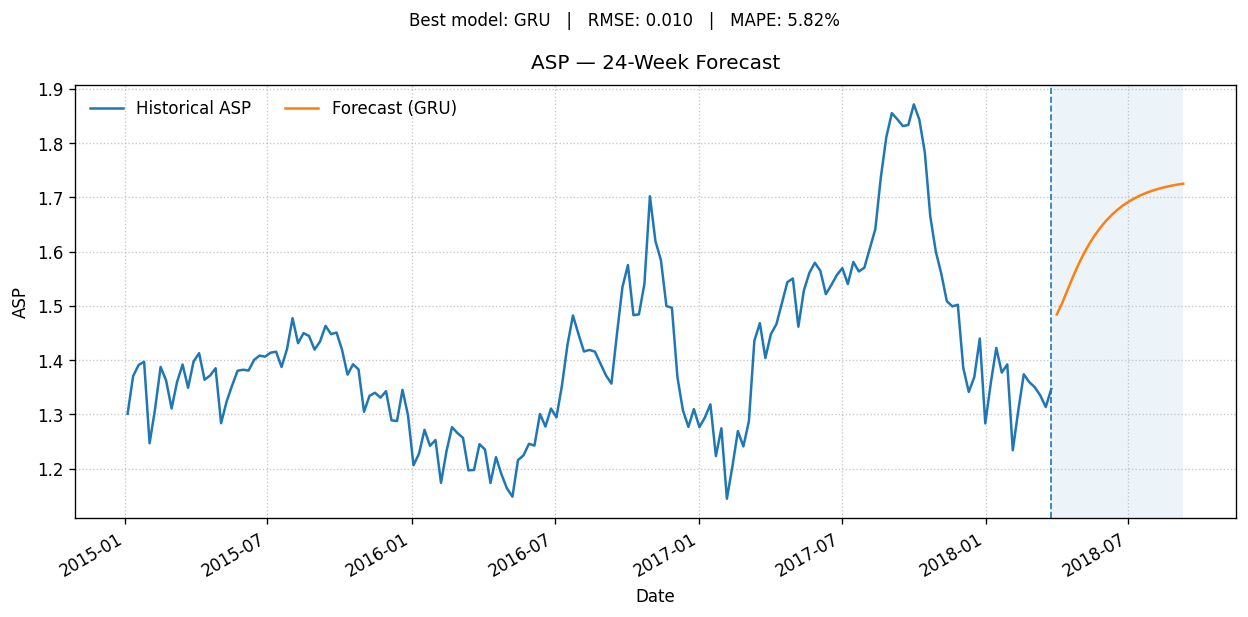

In [24]:

# Choose best model by MAPE (available ones)
best_name = metrics_df.iloc[0]['Model']
print('Best model by MAPE:', best_name)

steps_ahead = 24
f_index = future_index(series.index[-1], steps=steps_ahead, freq='W')

if best_name == 'ARIMA':
    (p,d,q) = best['order']
    best_full = SARIMAX(series, order=(p,d,q), seasonal_order=(0,0,0,0),
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
    fcast = best_full.get_forecast(steps=steps_ahead).predicted_mean

elif best_name == 'SARIMA':
    (o, so) = sbest['order'], sbest['sorder']
    best_full = SARIMAX(series, order=o, seasonal_order=so,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
    fcast = best_full.get_forecast(steps=steps_ahead).predicted_mean

elif best_name in ('LSTM','GRU') and tf is not None:
    window = 12
    # retrain on full series
    Xf, yf = make_supervised(series, window)
    if best_name == 'LSTM':
        model = keras.Sequential([layers.Input(shape=(window,1)), layers.LSTM(32), layers.Dense(1)])
    else:
        model = keras.Sequential([layers.Input(shape=(window,1)), layers.GRU(32), layers.Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(Xf, yf, epochs=8, batch_size=32, verbose=0, callbacks=[es])

    # iterative forecasting
    hist = series.values.astype('float32')
    window_vals = hist[-window:].tolist()
    preds = []
    for _ in range(steps_ahead):
        x = np.array(window_vals[-window:], dtype='float32').reshape(1, window, 1)
        pred = float(model.predict(x, verbose=0)[0,0])
        preds.append(pred)
        window_vals.append(pred)
    fcast = pd.Series(preds, index=f_index)
else:
    # Fallback: use SARIMA full
    (o, so) = sbest['order'], sbest['sorder']
    best_full = SARIMAX(series, order=o, seasonal_order=so,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
    fcast = best_full.get_forecast(steps=steps_ahead).predicted_mean

# plt.figure()
# plt.plot(series.index, series, label='Historical ASP')
# plt.plot(f_index, fcast, label=f'Forecast ({best_name})')
# plt.title('ASP — 24-Week Forecast'); plt.xlabel('Date'); plt.ylabel('ASP'); plt.legend(); plt.tight_layout(); plt.show()


from matplotlib.dates import AutoDateLocator, DateFormatter

# --- Build CI if available (ARIMA/SARIMA); DL models won't have CI ---
ci_lower = ci_upper = None
if best_name in ('ARIMA', 'SARIMA'):
    # recompute forecast object so we can access CI
    if best_name == 'ARIMA':
        (p,d,q) = best['order']
        best_full = SARIMAX(series, order=(p,d,q), seasonal_order=(0,0,0,0),
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)
    else:
        (o, so) = sbest['order'], sbest['sorder']
        best_full = SARIMAX(series, order=o, seasonal_order=so,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=80)

    _fc_obj = best_full.get_forecast(steps=steps_ahead)
    fcast = _fc_obj.predicted_mean  # keep your forecast
    _ci = _fc_obj.conf_int(alpha=0.05)
    ci_lower = _ci.iloc[:, 0]
    ci_upper = _ci.iloc[:, 1]

# --- Pull validation metrics for subtitle (if you built metrics_df earlier) ---
try:
    row = metrics_df.set_index('Model').loc[best_name]
    rmse_best, mape_best = float(row['RMSE']), float(row['MAPE'])
    subtitle = f'Best model: {best_name}   |   RMSE: {rmse_best:.3f}   |   MAPE: {mape_best:.2%}'
except Exception:
    subtitle = f'Best model: {best_name}'

# Ensure forecast is a pandas Series with the right index
if not isinstance(fcast, pd.Series):
    fcast = pd.Series(np.asarray(fcast).ravel(), index=f_index)

# --- Professional plot ---
fig, ax = plt.subplots(figsize=(10.5, 5.2), dpi=120)

# historical + forecast
ax.plot(series.index, series, label='Historical ASP')
ax.plot(f_index, fcast, label=f'Forecast ({best_name})')

# confidence band if available
if ci_lower is not None and ci_upper is not None:
    ax.fill_between(f_index, ci_lower, ci_upper, alpha=0.15, label='Forecast 95% CI')

# visually mark the forecast horizon
ax.axvspan(series.index[-1], f_index[-1], alpha=0.08)
ax.axvline(series.index[-1], linestyle='--', linewidth=1)

# titles
ax.set_title('ASP — 24-Week Forecast', pad=10)
fig.suptitle(subtitle, y=0.98, fontsize=10)

# axes formatting
ax.set_xlabel('Date')
ax.set_ylabel('ASP')
ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)

# readable date ticks
locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# legend & layout
ax.legend(frameon=False, ncol=2, loc='upper left')
fig.tight_layout()

# Optional: save for README/screenshots
# fig.savefig('../reports/figures/final_24wk_forecast.png', bbox_inches='tight')
plt.show()
